# Tokenizer config 作成（BPE Training）

In [1]:
import json
import tempfile
from pathlib import Path
from pprint import pprint

import pandas as pd
import tokenizers
from rdkit import Chem
from tqdm.auto import tqdm

from nncomp_molecule import constants

tqdm.pandas()

## Config

In [3]:
TOKENIZER_NAME = "bpe-10000"
OUTDIR = constants.INPUTDIR / "kfujikawa/bms-tokenizers-v1"
N_VOCAB = 10000
OUTDIR

PosixPath('/work/input/kfujikawa/bms-tokenizers-v1')

## Tokenizer作成

### Tokenizer configの作成

In [15]:
tokenizer = tokenizers.Tokenizer(
    tokenizers.models.BPE(),
)
tokenizer.pre_tokenizer = tokenizers.pre_tokenizers.Whitespace()
tokenizer.add_special_tokens(
    ["<PAD>", "<BOS>", "<EOS>", "<UNK>"]
)
tokenizer.post_processor = tokenizers.processors.TemplateProcessing(
    single="<BOS> $0 <EOS>",
    special_tokens=[("<BOS>", 1), ("<EOS>", 2)]
)
tokenizer.decoder = tokenizers.decoders.BPEDecoder()
tokenizer.add_tokens([
    "InChI=1S/",
    "Br", "Cl", "Si",
    "/c", "/h", "/t", "/m", "/s", "/b", "/i",
])

11

In [16]:
train_df = pd.read_csv(constants.COMPETITION_DATADIR / "train_labels.csv")

In [17]:
trainer = tokenizers.trainers.BpeTrainer(vocab_size=10000)
tokenizer.train_from_iterator(train_df.InChI, trainer)

## Configの保存

In [22]:
tokenizer.save(str(OUTDIR / f"{TOKENIZER_NAME}.json"))
tokenizer = tokenizers.Tokenizer.from_file(str(OUTDIR / f"{TOKENIZER_NAME}.json"))

## 検証

In [26]:
index = 0

inchi = train_df.InChI[index]
print(inchi)
encoding = tokenizer.encode(inchi)
print(json.dumps(encoding.tokens))
print(json.dumps(encoding.ids))

InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12(13)11(4)14/h5-7,9,11,14H,8H2,1-4H3
["<BOS>", "InChI=1S/", "C13H20", "OS", "/c", "1", "-", "9", "(", "2", ")", "8", "-", "15", "-", "13", "-", "6", "-", "5", "-", "10", "(", "3", ")", "7", "-", "12", "(", "13", ")", "11", "(", "4", ")", "14", "/h", "5", "-", "7", ",", "9", ",", "11", ",", "14H", ",", "8H2", ",", "1", "-", "4H3", "<EOS>"]
[1, 10004, 375, 444, 10005, 7, 4, 15, 0, 8, 1, 14, 4, 43, 4, 39, 4, 12, 4, 11, 4, 42, 0, 9, 1, 13, 4, 38, 0, 39, 1, 40, 0, 10, 1, 41, 10006, 11, 4, 13, 3, 15, 3, 40, 3, 92, 3, 125, 3, 7, 4, 110, 2]


In [24]:
json.dumps(tokenizer.encode("c-123").tokens)

'["<BOS>", "c", "-", "12", "3", "<EOS>"]'

In [25]:
n_tokens = train_df.InChI.progress_apply(lambda x: len(tokenizer.encode(x).tokens))
n_tokens.hist()
n_tokens.max()

263

<AxesSubplot:>

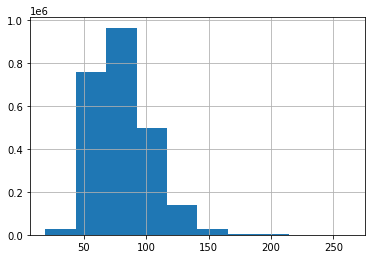

In [28]:
%matplotlib inline
n_tokens.hist()